In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
# load dataset
data_URL = "https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv"
data = pd.read_csv(data_URL, sep='\t')



Using TensorFlow backend.


In [2]:
import random
import nltk
from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from nltk.tokenize import word_tokenize
random.seed(2003)
documents = []

for phraseId in range(data.shape[0]):
  documents.append((word_tokenize(data['Phrase'].iloc[phraseId]), data['Sentiment'].iloc[phraseId]))

random.shuffle(documents)
print(documents[1][0])
print(documents[1][1])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
['ca', "n't", 'believe', 'anyone', 'would', 'really', 'buy', 'this', 'stuff']
0


In [3]:

porter = PorterStemmer()
lancaster=LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
stopwords_en = stopwords.words("english")
punctuations="?:!.,;'\"-()"

remove_stopwords = True
useStemming = False
useLemma = True
removePuncs = True
print(documents[1][0])

['ca', "n't", 'believe', 'anyone', 'would', 'really', 'buy', 'this', 'stuff']


In [4]:
for l in range(len(documents)):
  label = documents[l][1]
  tmpReview = []
  for w in documents[l][0]:
    newWord = w
    if remove_stopwords and (w in stopwords_en):
      continue
    if removePuncs and (w in punctuations):
      continue

    if useStemming:
      newWord = lancaster.stem(newWord)

    if useLemma:
      newWord = wordnet_lemmatizer.lemmatize(newWord)
    tmpReview.append(newWord)
  documents[l] = (tmpReview, label)
  documents[l] = (' '.join(tmpReview), label)

print(documents[1])

("ca n't believe anyone would really buy stuff", 0)


In [0]:
all_data = pd.DataFrame(documents, columns=['Phrase','Sentiment'])


In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.utils import np_utils

#converts the labels to categorical/onehot encoded for multiclass predictions
Y_categorical = np_utils.to_categorical(all_data["Sentiment"])

#stratify the data to keep the categories evenly distributed for better results
X_train, X_test, Y_train, Y_test = train_test_split(all_data["Phrase"],  all_data["Sentiment"], test_size=0.3, stratify = Y_categorical, random_state=2003)

vectorizer = TfidfVectorizer(stop_words="english", ngram_range = (1, 1))

X_train = vectorizer.fit_transform(X_train)

X_test = vectorizer.transform(X_test)




In [0]:
from keras import backend as K

#define metrics manually as they're not a part of keras anymore
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
from numpy import newaxis
#reshapes the training and testing inputs as proper input to the model
X_train_np = X_train.toarray()
X_train_reshaped = X_train_np[..., newaxis]
X_test_np = X_test.toarray()
X_test_reshaped = X_test_np[..., newaxis]

In [22]:
from keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten, Dense, GlobalAveragePooling1D
import time


#define the input and output structure
n_timesteps, n_features, n_outputs = X_train_reshaped.shape[1], X_train_reshaped.shape[2], Y_train.shape[1]

	# create model
model = Sequential()
model.add(Conv1D(filters=100, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=100, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=120, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=120, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
	# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_m, precision_m, recall_m])

startTime = time.perf_counter()
# fit the model
history = model.fit(X_train_reshaped, Y_train, epochs=100, batch_size = 64, verbose=1)

endTime = time.perf_counter()
trainingTime = endTime-startTime

print("Total training time: " + str(trainingTime))

# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test_reshaped, Y_test, batch_size = 64, verbose=0)

print("accuracy: "+ str(accuracy))
print("LOSS: "+ str(loss))
print("precision: "+ str(precision))
print("recall: "+str(recall))
print("F1 score: "+str(f1_score))


 


Epoch 1/10
109242/109242 [==============================] - 113s 1ms/step - loss: 1.0950 - acc: 0.5577 - f1_m: 0.4745 - precision_m: 0.6635 - recall_m: 0.3765
Epoch 2/10
109242/109242 [==============================] - 112s 1ms/step - loss: 0.9501 - acc: 0.6165 - f1_m: 0.5680 - precision_m: 0.6942 - recall_m: 0.4825
Epoch 3/10
109242/109242 [==============================] - 111s 1ms/step - loss: 0.8646 - acc: 0.6504 - f1_m: 0.6186 - precision_m: 0.7080 - recall_m: 0.5506
Epoch 4/10
109242/109242 [==============================] - 111s 1ms/step - loss: 0.8023 - acc: 0.6750 - f1_m: 0.6534 - precision_m: 0.7218 - recall_m: 0.5979
Epoch 5/10
109242/109242 [==============================] - 111s 1ms/step - loss: 0.7575 - acc: 0.6922 - f1_m: 0.6754 - precision_m: 0.7332 - recall_m: 0.6269
Epoch 6/10
109242/109242 [==============================] - 111s 1ms/step - loss: 0.7213 - acc: 0.7069 - f1_m: 0.6931 - precision_m: 0.7425 - recall_m: 0.6507
Epoch 7/10
109242/109242 [====================

dict_keys(['loss', 'acc', 'f1_m', 'precision_m', 'recall_m'])


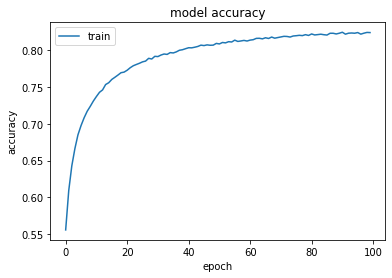

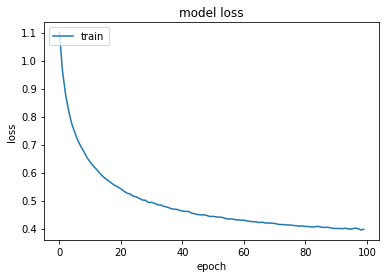

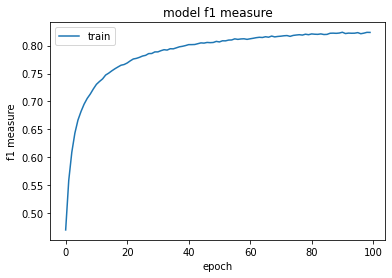

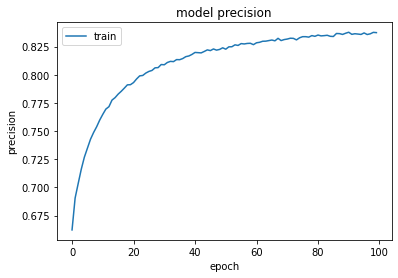

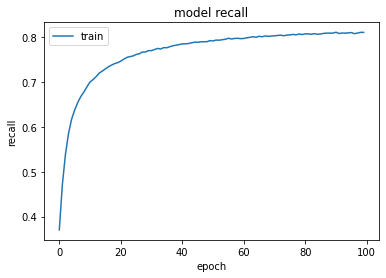

In [11]:
import matplotlib.pyplot as plt

print(history.history.keys())

# summarize history for all measures and plot them
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['f1_m'])
plt.title('model f1 measure')
plt.ylabel('f1 measure')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_m'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_m'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.save('0655603_1dconv_reg.pt')